In [2]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [3]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier

from sklearn.metrics import (roc_auc_score)


In [5]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [7]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

#Read Dataset

In [8]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [9]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=43)

In [10]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 106
    
print(seed_number)

106


#Params

In [11]:
params_dict = ri.params_dict

In [12]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [13]:
df_train, policy_model = ri.fit_policy(df_train)

In [14]:
X_train = df_train
y_train = df_train["TARGET"]

X_test = df_test
y_test = df_test["TARGET"]

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed_number)

In [16]:
X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model)
X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model)

In [17]:
print(y_val_acp.mean(), y_val_rej.mean())

0.05024424284717376 0.09401074658162596


In [18]:
dex.get_shapes(X_train_acp, X_train_rej, X_val_acp, X_val_rej, X_test, )

X_train_acp : (35093, 15)
X_train_rej : (90862, 15)
X_val_acp : (8598, 15)
X_val_rej : (22891, 15)
df_test : (49202, 122)


In [19]:
# study_lgbm, model_lgbm = tr.optimize_model(LGBMClassifier, tr.hyperparam_spaces["LGBMClassifier"], 
#                                         X_train_acp, y_train_acp, n_trials=100)

In [20]:
# lgbm3 = study_lgbm.best_params

#<font color='red'>PIPELINE NORMAL</font>


In [21]:
models_dict = {}

In [22]:
clf_original = tr.create_pipeline(X_train_acp, y_train_acp,
                                  LGBMClassifier(**params_dict['LightGBM_2']))
clf_original.fit(X_train_acp, y_train_acp)

models_dict['original'] = clf_original

ri.get_metrics_RI(models_dict, X_test, y_test)

,original
Overall AUC,0.735742
KS,0.35621
------,
Balanced Accuracy,0.678105
Accuracy,0.708264
Precision,0.162594
Recall,0.642237
F1,0.259492


In [23]:
# from types import NoneType
# from sklearn.metrics import roc_curve


# def get_metrics_RI(name_model_dict, X, y, X_v = None, y_v = None,
#                    X_unl = None, threshold_type = 'default', acp_rate = 0.15):
#     def get_best_threshold_with_ks(model, X, y):
#         y_probs = model.predict_proba(X)[:,1]
#         fpr, tpr, thresholds = roc_curve(y, y_probs)
#         return thresholds[np.argmax(tpr - fpr)]

#     models_dict = {}
#     for name, model in name_model_dict.items():
#         if isinstance(model, list):
#             y_prob = model[0].predict_proba(X)[:,1]
#             threshold_model = model[1]
#             y_pred = (y_prob >= threshold_model).astype('int')
#         else:
#             if threshold_type == 'default':
#                 threshold = 0.5
#             elif threshold_type == 'ks':
#                 if np.any(X_v):
#                     threshold = get_best_threshold_with_ks(model, X_v, y_v)
#                 else:
#                     threshold = get_best_threshold_with_ks(model, X, y)
#             elif threshold_type == 'risk':
#                 if np.any(X_v):
#                     threshold = ri.risk_score_threshold(model, X_v, y_v)
#                 else:
#                     threshold = ri.risk_score_threshold(model, X, y)

#             y_prob = model.predict_proba(X)[:,1]
#             y_pred = (y_prob >= threshold).astype('int')

#         models_dict[name] = (y_pred, y_prob)

#     def evaluate_ks(y_real, y_proba):
#         ks = ks_2samp(y_proba[y_real == 0], y_proba[y_real == 1])
#         return ks.statistic

#     def get_metrics_df(models_dict, y_true,):
#         metrics_dict = {
#             "Overall AUC": (
#                 lambda x: roc_auc_score(y_true, x), False),
#             "KS": (
#                 lambda x: evaluate_ks(y_true, x), False),
#             "------": (lambda x: "", True),
#             "Balanced Accuracy": (
#                 lambda x: balanced_accuracy_score(y_true, x), True),
#             "Accuracy": (
#                 lambda x: accuracy_score(y_true, x), True),
#             "Precision": (
#                 lambda x: precision_score(y_true, x), True),
#             "Recall": (
#                 lambda x: recall_score(y_true, x), True),
#             "F1": (
#                 lambda x: f1_score(y_true, x), True),
#             "-----": (lambda x: "", True),
#         }
#         df_dict = {}
#         for metric_name, (metric_func, use_preds) in metrics_dict.items():
#             df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores)
#                                     for model_name, (preds, scores) in models_dict.items()]
#         return df_dict

#     df_dict = get_metrics_df(models_dict, y)
#     if isinstance(X_v, NoneType):
#         if isinstance(X_unl, NoneType) or ('original' not in name_model_dict):
#             del df_dict["-----"]

#     if np.any(X_v):
#         df_dict['Approval Rate'] = []
#     if np.any(X_unl) and 'original' in name_model_dict:
#         df_dict['Kickout'] = []
#         df_dict['KG'] = []
#         df_dict['KB'] = []

#     for name, model in name_model_dict.items():
#         if name != 'original':
#             if isinstance(model, list):
#                 if np.any(X_v):
#                     df_dict['Approval Rate'].append(ri.calculate_approval_rate(model[0], X_v, y_v, X))
#                 if np.any(X_unl) and 'original' in name_model_dict:
#                     kickout, kg, kb = ri.calculate_kickout_metric(name_model_dict['original'][0], model[0], X, y, X_unl, acp_rate)
#                     df_dict['Kickout'].append(kickout*10)
#                     df_dict['KG'].append(kg)
#                     df_dict['KB'].append(kb)
#             else:
#                 if np.any(X_v):
#                     df_dict['Approval Rate'].append(ri.calculate_approval_rate(model, X_v, y_v, X))
#                 if np.any(X_unl) and 'original' in name_model_dict:
#                     if isinstance(name_model_dict["original"], list):
#                         original = name_model_dict["original"][0]  # Assuming "original" is a list
#                     else:
#                         original = name_model_dict["original"]

#                     kickout, kg, kb = ri.calculate_kickout_metric(original, model, X, y, X_unl, acp_rate)
#                     df_dict['Kickout'].append(kickout*10)
#                     df_dict['KG'].append(kg)
#                     df_dict['KB'].append(kb)
#         else:
#             if np.any(X_v):
#                 if isinstance(model,list):
#                     df_dict['Approval Rate'].append(ri.calculate_approval_rate(model[0], X_v, y_v, X))
#                 else:
#                     df_dict['Approval Rate'].append(ri.calculate_approval_rate(model, X_v, y_v, X))
#             if np.any(X_unl) and 'original' in name_model_dict:
#                 df_dict['Kickout'].append(0)
#                 df_dict['KG'].append(0)
#                 df_dict['KB'].append(0)

#     metrics_df = pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())
#     return metrics_df

#<font color='green'>REJECT INFERENCE</font>

In [24]:
import warnings
warnings.filterwarnings("ignore")

#<font color='green'>Test others strategies:</font>

In [25]:
X_train, X_unl, y_train, y_unl = X_train_acp, X_train_rej, y_train_acp, y_train_rej

In [26]:
models_dict.update(ri.augmentation_with_soft_cutoff(X_train, y_train, X_unl, seed = seed_number))
models_dict.update(ri.augmentation(X_train, y_train, X_unl, mode='up', seed = seed_number))
models_dict.update(ri.augmentation(X_train, y_train, X_unl, mode='down', seed = seed_number))
models_dict.update(ri.fuzzy_augmentation(X_train, y_train, X_unl, seed = seed_number))
models_dict.update(ri.extrapolation(X_train, y_train, X_unl, mode = "confident", seed = seed_number))
models_dict.update(ri.parcelling(X_train, y_train, X_unl, seed = seed_number))
models_dict.update(ri.label_spreading(X_train, y_train, X_unl, seed = seed_number))
ri.get_metrics_RI(models_dict, X_test, y_test, X_unl = X_val_rej)

,original,aug_SC,aug_up,aug_down,fuzzy,ext,parcelling,labelSpr
Overall AUC,0.735742,0.720975,0.730878,0.733909,0.726104,0.738227,0.733193,0.731134
KS,0.35621,0.334379,0.347312,0.359394,0.339501,0.35203,0.349133,0.344767
------,,,,,,,,
Balanced Accuracy,0.678105,0.66719,0.673656,0.679697,0.66975,0.676015,0.674567,0.672383
Accuracy,0.708264,0.681944,0.670013,0.703894,0.740336,0.703772,0.695094,0.651782
Precision,0.162594,0.15124,0.150596,0.161831,0.170583,0.160433,0.157374,0.146131
Recall,0.642237,0.649642,0.677988,0.650919,0.585802,0.643003,0.650153,0.696885
F1,0.259492,0.245359,0.246449,0.259216,0.264225,0.256795,0.253409,0.241601
-----,,,,,,,,
Kickout,0,0.413874,0.243209,0.264182,0.54816,0.514553,0.486401,0.597361


#<font color='green'>Test Trusted Non-outliers Inference:</font>

    * Loop through rejects selecting most confident predictions on outliers as Accepts

In [27]:
classifiers_to_test = [
                        LGBMClassifier,
                        # DecisionTreeClassifier,
                        # RandomForestClassifier,
                        # LogisticRegression,
                        ]

classifiers_names = [
                        'LightGBM_2',
                        # 'DecisionTree_1',
                        # 'RandomForest_1',
                        # 'LG_1',
                        ]

In [28]:
# X_train, X_t, y_train, y_t = train_test_split(X_train, y_train, test_size = 0.8, random_state=seed_number, stratify=y_train)
# X_unl, X_t, y_unl, y_t = train_test_split(X_unl, y_unl, test_size = 0.9, random_state=seed_number, stratify=y_unl)

In [29]:
updated_X_train, updated_y_train, updated_X_unl, updated_y_unl = X_train, y_train, X_unl, y_unl

In [ ]:
#@title run_confident_non_outliers
# (updated_X_train, updated_y_train, updated_X_unl, updated_y_unl) = (results_dict['LightGBM_2']['updated_X_train_list'][-1],
#                                                                     results_dict['LightGBM_2']['updated_y_train_list'][-1],
#                                                                     results_dict['LightGBM_2']['updated_X_unl_list'][-1],
#                                                                     results_dict['LightGBM_2']['updated_y_unl_list'][-1],
#                                                                     )

contamination_threshold = 0.1  # Specify the desired contamination threshold
iterations = 50 # Number of iterations
size = 1000

results_dict = {}

def run_confident_non_outliers(classifier_list, contamination_threshold, iterations, size, updated_X_train, updated_y_train,
                                 updated_X_unl, X_test, y_test):
    clf_iterations = []
    updated_X_train_list = []
    updated_y_train_list = []
    updated_X_unl_list = []
    list_of_probs = []

    for i in range(iterations):
        # print('**********************************************************************************')
        print(f'iteration {i}')
        # print('---------------------------------------------------------------------------------')
        # print(np.random.choice(sentences_list))
        # print('---------------------------------------------------------------------------------')
        classifier_to_use = classifier_list[i]
        updated_X_train, updated_y_train, updated_X_unl = ri.trusted_non_outliers(
                                            contamination_threshold, size,
                                            updated_X_train, updated_y_train,
                                            updated_X_unl, 
                                            seed=seed_number)

        clf_i = tr.create_pipeline(updated_X_train, updated_y_train, classifier_to_use,
                                onehot=True, normalize=True, do_EBE=True)
        clf_i.fit(updated_X_train, updated_y_train)
        y_prob_i = clf_i.predict_proba(X_test)[:,1]
        # print('auc_{}'.format(i), roc_auc_score(y_test, y_prob_i))


        clf_iterations.append(clf_i)
        updated_X_train_list.append(updated_X_train)
        updated_y_train_list.append(updated_y_train)
        updated_X_unl_list.append(updated_X_unl)
        list_of_probs.append(y_prob_i)

        kik, kg, kb = ri.calculate_kickout_metric(clf_original,clf_i, X_test, y_test, X_val_rej,  0.05)
        if kik*10 >= 0.5:
            break

    info_dict = {
    'clf_iterations': clf_iterations,
    'updated_X_train_list': updated_X_train_list,
    'updated_y_train_list': updated_y_train_list,
    'updated_X_unl_list': updated_X_unl_list,
    'list_of_probs': list_of_probs }

    return info_dict

for mclass, name in zip(classifiers_to_test, classifiers_names):
    print('+++++++++++++++++++++++++', name, '+++++++++++++++++++++++++')
    classifiers_to_iter = [mclass(**params_dict[name]) for i in range(iterations)]
    info_dict = run_confident_non_outliers(classifiers_to_iter, contamination_threshold, iterations,
                                            size,
                                            updated_X_train, updated_y_train,
                                            updated_X_unl,
                                            X_test, y_test)

    results_dict[name] = info_dict

In [31]:
import credit_pipeline.reject_inference as ri

In [ ]:
def run_confident_non_outliers(classifier, X_train, y_train, X_unl,
                                iterations = 50, 
                                contamination_threshold = 0.1,
                                size = 1000, 
                                clf_class = LGBMClassifier,
                                clf_params = params_dict["LightGBM_2"],
                                seed_number = 880,
                               ):
    clf_original = tr.create_pipeline(X_train, y_train, clf_class(**clf_params),
                                onehot=True, normalize=True, do_EBE=True)
    clf_original.fit(X_train, y_train)
    clf_original.predict_proba(X_test)[:,1]

    log_dict = {
        "train_index": {0: X_train.index}, 
        "unl_index": {0: X_unl.index},
        "clf": {"original": clf_original} 
        }
    updated_X_train, updated_y_train, updated_X_unl =  X_train, y_train, X_unl
    for i in range(iterations):
        updated_X_train, updated_y_train, updated_X_unl = ri.trusted_non_outliers(
                                            updated_X_train, updated_y_train, updated_X_unl, 
                                            contamination_threshold, size, 
                                            clf_class, clf_params, seed_number,
                                            )
        


In [ ]:
#@title Example usage create_pipeline
clf_name = "LightGBM_2" #@param ["LightGBM_2", "DecisionTree_1", "RandomForest_1", "LG_1"]
if clf_name == "LightGBM_2":
    clf_model = LGBMClassifier
elif clf_name == "DecisionTree_1":
    clf_model = DecisionTreeClassifier
elif clf_name == "RandomForest_1":
    clf_model = RandomForestClassifier
elif clf_name == "LG_1":
    clf_model = LogisticRegression



clf_original = tr.create_pipeline(X_train, y_train,
                               clf_model(**params_dict[clf_name]),
                               onehot=True, onehotdrop = True, normalize=True, do_EBE=True)
clf_original.fit(X_train, y_train)
y_prob = clf_original.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_prob))

In [34]:
models_dict_iter = {'original': clf_original}
models_dict_iter.update({'clf_' + str(i): element for i, element in enumerate(results_dict[clf_name]['clf_iterations'])})

metrics = ri.get_metrics_RI(models_dict_iter, X_test, y_test, X_val_acp, y_val_acp, X_val_rej, threshold_type = 'ks', acp_rate=0.05)
metrics

,original,clf_0,clf_1,clf_2,clf_3,clf_4,clf_5,clf_6,clf_7,clf_8,...,clf_40,clf_41,clf_42,clf_43,clf_44,clf_45,clf_46,clf_47,clf_48,clf_49
Overall AUC,0.734596,0.730329,0.729037,0.729709,0.728624,0.727575,0.728622,0.728184,0.728017,0.727214,...,0.708549,0.708504,0.708051,0.707323,0.706344,0.705036,0.70477,0.70277,0.701909,0.700755
KS,0.348012,0.340167,0.343273,0.342016,0.346253,0.345765,0.347436,0.345514,0.346213,0.345721,...,0.316299,0.312993,0.311738,0.308473,0.307416,0.3051,0.301506,0.302434,0.297759,0.295463
------,,,,,,,,,,,...,,,,,,,,,,
Balanced Accuracy,0.667732,0.668889,0.66329,0.668037,0.671736,0.668573,0.670414,0.670598,0.670788,0.672201,...,0.655235,0.654015,0.653775,0.652125,0.650002,0.650852,0.649226,0.646751,0.643198,0.641722
Accuracy,0.585891,0.608634,0.578574,0.597618,0.614304,0.603329,0.606073,0.639263,0.617068,0.639852,...,0.689139,0.645238,0.625686,0.675684,0.684444,0.669261,0.653815,0.699931,0.711211,0.697329
Precision,0.133446,0.137181,0.131211,0.135232,0.138946,0.136256,0.137221,0.143056,0.139127,0.143676,...,0.148688,0.138825,0.135342,0.144368,0.145604,0.14251,0.138829,0.148203,0.149826,0.14557
Recall,0.765066,0.740552,0.764045,0.751788,0.740041,0.74617,0.746936,0.707865,0.734678,0.710674,...,0.614913,0.664454,0.687181,0.624106,0.60904,0.628958,0.643769,0.583504,0.562308,0.575587
F1,0.227254,0.231481,0.22396,0.22923,0.233964,0.230433,0.231848,0.238011,0.23395,0.239028,...,0.239471,0.229666,0.226144,0.234493,0.235022,0.232369,0.228403,0.236371,0.236609,0.232371
-----,,,,,,,,,,,...,,,,,,,,,,
Approval Rate,0.837933,0.858278,0.856733,0.852689,0.858461,0.852953,0.864457,0.85399,0.86218,0.8509,...,0.875899,0.880472,0.88348,0.878277,0.878257,0.879314,0.877038,0.877383,0.868725,0.871245


In [52]:
metrics_techniques = ri.get_metrics_RI(models_dict, X_test, y_test, 
                                    X_val_acp, y_val_acp, X_unl =  X_val_rej,
                                    threshold_type = 'ks', acp_rate = 0.15)

metrics_techniques


,original,aug_SC,aug_up,aug_down,fuzzy,ext,parcelling,labelSpr,last
Overall AUC,0.735742,0.720975,0.730878,0.733909,0.726104,0.738227,0.733193,0.731134,0.700755
KS,0.35621,0.334379,0.347312,0.359394,0.339501,0.35203,0.349133,0.344767,0.295463
------,,,,,,,,,
Balanced Accuracy,0.663084,0.650719,0.67205,0.670597,0.615697,0.655524,0.65853,0.650589,0.641722
Accuracy,0.562091,0.54577,0.645157,0.614569,0.394557,0.512317,0.535242,0.516544,0.697329
Precision,0.129061,0.123924,0.144671,0.138651,0.105053,0.121822,0.124837,0.120999,0.14557
Recall,0.783197,0.775536,0.704035,0.737232,0.878703,0.825843,0.805158,0.81001,0.575587
F1,0.221604,0.2137,0.240021,0.233406,0.187669,0.212323,0.216159,0.210547,0.232371
-----,,,,,,,,,
Approval Rate,0.853624,0.858603,0.852587,0.863095,0.627495,0.789236,0.773464,0.839905,0.871245


In [ ]:
first = dex.get_shapes(results_dict[clf_name]['updated_y_train_list'][0])
last = dex.get_shapes(results_dict[clf_name]['updated_y_train_list'][-1])

None : (36093,)
None : (79093,)


In [ ]:
y_mean_list = [y.mean() for y in results_dict[clf_name]['updated_y_train_list']]

In [ ]:
auc0 = metrics.T['Overall AUC']['original']
auc0

0.7345960055842118

In [ ]:
auc_loss = [(auc0 - a) for a in metrics.T['Overall AUC']][1:]

paralell coordinate plot

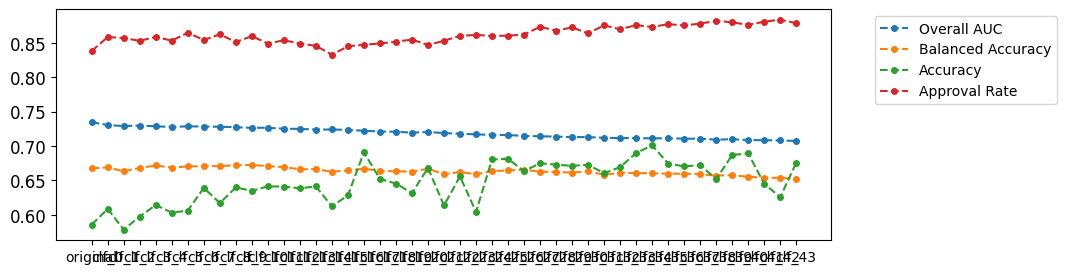

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

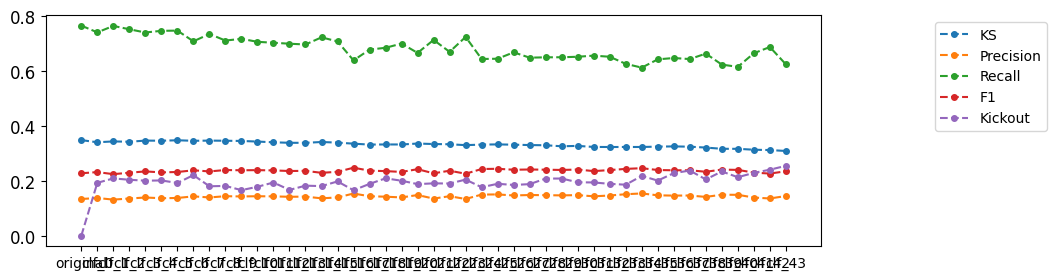

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

In [ ]:
# C1 = clf_original
# kickout_results = []

# for c2 in results_dict[clf_name]['clf_iterations']:
#     k, kg, kb = ri.calculate_kickout_metric(C1,c2, X_test, y_test, X_val_rej, 0.05)
#     kickout_results.append(k)
#     print(k)

In [ ]:
# plt.plot(kickout_results, marker='o', markersize=3, linestyle='-', label = 'kickout')
# plt.plot(y_mean_list, marker='o', markersize=3, linestyle='-', label = 'y_mean_list')
# plt.plot(auc_loss, marker='o', markersize=3, linestyle='-', label = 'auc_loss')
# plt.legend()

In [ ]:
# AR_original = ri.calculate_approval_rate(clf_original, X_val_acp, y_val_acp, X_test)
# AR_original

In [ ]:
# thrs = []
# for clf_ri in results_dict[clf_name]['clf_iterations']:
#     thr = ri.risk_score_threshold(clf_ri, X_val_acp, y_val_acp)
#     thrs += [thr]

In [ ]:
# AR = []
# for c2, thr in zip(results_dict[clf_name]['clf_iterations'], thrs):
#     k = ri.calculate_approval_rate(c2, X_val_acp, y_val_acp, X_test)
#     AR.append(k)
#     # print(k)

In [ ]:
# plt.plot(AR)
# plt.plot(np.arange(len(AR)), [AR_original]*len(AR))

In [ ]:
print(time.localtime().__reduce__())

(<class 'time.struct_time'>, ((2023, 11, 29, 13, 19, 24, 2, 333, 0), {'tm_zone': '-03', 'tm_gmtoff': -10800}))


In [ ]:
# metrics_poster = metrics_techniques.loc[["Overall AUC", "Kickout"],:]
# metrics_poster = metrics_poster.astype(float).round(3)
# metrics_poster

In [ ]:
# from pathlib import Path
# filepath = Path(os.path.join(save_path,str(seed_number)+'_metrics_poster.csv'))
# filepath.parent.mkdir(parents=True, exist_ok=True)
# metrics_poster.to_csv(filepath)